## Seizure Detection Challenge (2025) 

This notebook implements a seizure detection pipeline using EEG data from the BIDS-formatted Siena Scalp EEG Dataset. We'll go through the following steps:

#### 1. Data loading and preprocessing
#### 2. Creating a PyTorch dataset
#### 3. Building and training a CNN model
#### 4. Evaluating the results


In [20]:
#Imports
import mne
import mne_bids
from bids import BIDSLayout
import numpy as np
import pandas as pd
from pathlib import Path
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import logging
from typing import Dict, List, Optional, Tuple, Any
from scipy import signal

# Set the maximum number of columns to display
pd.set_option('display.max_columns', None) 

import warnings
#warnings.filterwarnings("ignore")

In [21]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

### Exploratory Data Analysis

In [22]:
#BIDS_Siena Sub 00 ses-01 run 00
sub00ses01run00 = r"C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg\sub-00_ses-01_task-szMonitoring_run-00_eeg.edf"
sub00ses01run00 = mne.io.read_raw_edf(sub00ses01run00, preload=True)
print(sub00ses01run00.info)

Extracting EDF parameters from C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg\sub-00_ses-01_task-szMonitoring_run-00_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 671999  =      0.000 ...  2624.996 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fp1-Avg, F3-Avg, C3-Avg, P3-Avg, O1-Avg, F7-Avg, T3-Avg, T5-Avg, ...
 chs: 19 EEG
 custom_ref_applied: False
 highpass: 1.6 Hz
 lowpass: 30.0 Hz
 meas_date: 2016-01-01 19:39:33 UTC
 nchan: 19
 projs: []
 sfreq: 256.0 Hz
 subject_info: 3 items (dict)
>


In [23]:
#View Channel Names
print(sub00ses01run00.ch_names)

['Fp1-Avg', 'F3-Avg', 'C3-Avg', 'P3-Avg', 'O1-Avg', 'F7-Avg', 'T3-Avg', 'T5-Avg', 'Fz-Avg', 'Cz-Avg', 'Pz-Avg', 'Fp2-Avg', 'F4-Avg', 'C4-Avg', 'P4-Avg', 'O2-Avg', 'F8-Avg', 'T4-Avg', 'T6-Avg']


In [24]:
sub00ses01run00.plot(duration=10, n_channels=19)

In [25]:
# Extract EEG data as a NumPy array
eeg_data = sub00ses01run00.get_data()
channel_names = sub00ses01run00.ch_names

# Compute basic statistics
eeg_stats = pd.DataFrame({
    "Channel": channel_names,
    "Mean": np.mean(eeg_data, axis=1),
    "Std Dev": np.std(eeg_data, axis=1),
    "Min": np.min(eeg_data, axis=1),
    "Max": np.max(eeg_data, axis=1)
})

# Display the computed statistics
print(eeg_stats)


    Channel          Mean   Std Dev       Min       Max
0   Fp1-Avg -4.934503e-07  0.000049 -0.000430  0.001162
1    F3-Avg  1.461965e-08  0.000020 -0.000239  0.000494
2    C3-Avg -2.182140e-06  0.000016 -0.000343  0.000216
3    P3-Avg -1.308922e-06  0.000026 -0.000308  0.000950
4    O1-Avg -1.614275e-06  0.000095 -0.001081  0.002979
5    F7-Avg  1.795892e-06  0.000035 -0.000349  0.000406
6    T3-Avg -4.000901e-07  0.000022 -0.000466  0.000198
7    T5-Avg  3.125583e-06  0.000018 -0.000402  0.000203
8    Fz-Avg  4.814427e-07  0.000019 -0.000217  0.000315
9    Cz-Avg -4.819394e-06  0.000041 -0.000250  0.001165
10   Pz-Avg -1.682614e-06  0.000036 -0.000280  0.001136
11  Fp2-Avg  2.336533e-06  0.000055 -0.000461  0.001377
12   F4-Avg -4.353400e-07  0.000021 -0.000211  0.000637
13   C4-Avg -2.405176e-06  0.000017 -0.000202  0.000224
14   P4-Avg  9.287732e-07  0.000017 -0.000206  0.000174
15   O2-Avg  6.411352e-07  0.000026 -0.000304  0.000235
16   F8-Avg  2.965402e-06  0.000044 -0.000449  0

Computes the mean, standard deviation, min and max values for each EEG channel.

Helps in detecting anomalies, identifying bad channels and understanding the data distribution.

In [26]:
#Loading Seizure Annotations
sub00ses01run00_annotations = r"C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg\sub-00_ses-01_task-szMonitoring_run-00_events.tsv"
sub00ses01run00_annotations = pd.read_csv(sub00ses01run00_annotations, sep='\t')
print(sub00ses01run00_annotations.head())

    onset  duration  eventType  confidence channels             dateTime  \
0  1143.0      70.0  sz_foc_ia         NaN    T4,T6  2016-01-01 19:39:33   

   recordingDuration  
0             2625.0  


In [27]:
# Create MNE Annotations object
mne_annotations = mne.Annotations(
    onset=sub00ses01run00_annotations["onset"].values,
    duration=sub00ses01run00_annotations["duration"].values,
    description=sub00ses01run00_annotations["eventType"].values
)

# Set annotations to the raw EEG object
sub00ses01run00.set_annotations(mne_annotations)

# Plot EEG data with annotations
sub00ses01run00.plot()

# Print first few rows of the annotations DataFrame
print(sub00ses01run00_annotations.head())

    onset  duration  eventType  confidence channels             dateTime  \
0  1143.0      70.0  sz_foc_ia         NaN    T4,T6  2016-01-01 19:39:33   

   recordingDuration  
0             2625.0  


Electrode Labels on the left
    - These are the the EEG channel names corresponding to the standard 10-20 system electrode placements
EEG Signal Traces
    -Each Channel shows its recorded electrical activity over time in microvolts (µV). These signals represent the brain activity, and you may observe rhythmic patterns, spikes, or artifacts.
Time Axis (x-axis)

Highlighted Blue
    -Added Annotation (probably start and duration of seizure event)

In [28]:
 # Set up paths
initial_path = Path(r"C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena")
#bids_root = verify_paths(initial_path)

In [29]:
# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

#### Data Handling Classes and Functions
- Define our custom Dataset class for handling EEG data and our path verification function.

In [30]:
class SeizureDataset(Dataset):
    """
    Custom Dataset for handling EEG seizure data.
    Converts numpy arrays to PyTorch tensors and provides standard dataset functionality.
    """
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)
        
    def __len__(self) -> int:
        return len(self.X)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.X[idx], self.y[idx]

def verify_paths(bids_root: Path) -> Path:
    """
    Verify and construct the correct path to the BIDS dataset.
    Handles the nested BIDS_Siena directory structure.
    """
    bids_root = Path(bids_root)
    actual_bids_root = bids_root / "BIDS_Siena"
    
    if not actual_bids_root.exists():
        raise FileNotFoundError(
            f"BIDS directory not found at: {actual_bids_root}\n"
            f"Please check if the path is correct."
        )
    
    logger.info(f"Verified BIDS directory at: {actual_bids_root}")
    return actual_bids_root


#### Feature Engineering: Adding Spectral Features


In [31]:
def extract_spectral_features(data: np.ndarray, sfreq: float = 256.0) -> np.ndarray:
    """
    Extract spectral features from EEG data to better capture seizure patterns.
    
    Args:
        data: EEG data array of shape (n_channels, n_samples)
        sfreq: Sampling frequency in Hz
    
    Returns:
        Spectral features of shape (n_channels, n_bands)
    """
    n_channels = data.shape[0]
    
    # Define frequency bands of interest
    bands = [
        (0.5, 4),    # Delta
        (4, 8),      # Theta
        (8, 12),     # Alpha
        (12, 16),    # Low Beta
        (16, 30),    # High Beta
        (30, 50)     # Gamma
    ]
    
    n_bands = len(bands)
    features = np.zeros((n_channels, n_bands))
    
    for ch in range(n_channels):
        # Calculate power spectral density using Welch's method
        freqs, psd = signal.welch(data[ch], fs=sfreq, nperseg=min(256, len(data[ch])))
        
        # Extract band powers
        for i, (low, high) in enumerate(bands):
            # Find indices corresponding to frequency band
            idx = np.logical_and(freqs >= low, freqs <= high)
            
            # Calculate average power in band
            if np.any(idx):
                features[ch, i] = np.mean(psd[idx])
            else:
                features[ch, i] = 0
    
    return features

def enhance_window_features(windows: np.ndarray, sfreq: float = 256.0) -> np.ndarray:
    """
    Enhance window features with spectral information.
    
    Args:
        windows: EEG data of shape (n_windows, n_channels, window_size)
        sfreq: Sampling frequency in Hz
    
    Returns:
        Enhanced features of shape (n_windows, n_channels, window_size + n_spectral_features)
    """
    n_windows, n_channels, window_size = windows.shape
    
    # Extract 6 spectral bands per channel
    n_spectral_features = 6
    
    # Initialize array for enhanced features (original + spectral)
    enhanced_windows = windows.copy()
    spectral_features = np.zeros((n_windows, n_channels, n_spectral_features))
    
    # Process each window
    for i in range(n_windows):
        # Extract spectral features for this window
        spec_features = extract_spectral_features(windows[i], sfreq)
        spectral_features[i] = spec_features
    
    logger.info(f"Added {n_spectral_features} spectral features per channel")
    return spectral_features

#### Data Loading and Processing Functions
- Implement functions to load and process our EEG recordings. We'll add comprehensive metrics calculation.

In [32]:
def load_single_recording(
    eeg_file: Path,
    events_file: Path,
    window_size: int = 256, 
    overlap: float = 0.5,
    add_spectral: bool = True
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Load and process a single EEG recording with its corresponding events.
    Now includes spectral feature extraction.
    
    Args:
        eeg_file: Path to the .edf file
        events_file: Path to the events.tsv file
        window_size: Number of samples in each window
        overlap: Fraction of overlap between consecutive windows
        add_spectral: Whether to add spectral features
        
    Returns:
        Tuple of (processed_data, spectral_features, labels)
    """
    try:
        # Load EEG data
        logger.info(f"Loading EEG file: {eeg_file.name}")
        raw = mne.io.read_raw_edf(eeg_file, preload=True)
        
        # Load events
        logger.info(f"Loading events from: {events_file.name}")
        events_df = pd.read_csv(events_file, sep='\t')
        
        # Get EEG data and parameters
        data = raw.get_data()
        sfreq = raw.info['sfreq']
        
        # Calculate windowing parameters
        stride = int(window_size * (1 - overlap))
        n_windows = (data.shape[1] - window_size) // stride + 1
        
        # Initialize arrays
        windows = np.zeros((n_windows, data.shape[0], window_size))
        labels = np.zeros(n_windows)
        
        # Process each window
        for i in range(n_windows):
            start_idx = i * stride
            end_idx = start_idx + window_size
            windows[i] = data[:, start_idx:end_idx]
            
            # Convert to time
            window_start_time = start_idx / sfreq
            window_end_time = end_idx / sfreq
            
            # Check for seizure events
            for _, event in events_df.iterrows():
                if event['eventType'].startswith('sz'):
                    event_start = event['onset']
                    event_end = event_start + event['duration']
                    
                    if (window_start_time <= event_end and 
                        window_end_time >= event_start):
                        labels[i] = 1
                        break
        
        # Extract spectral features if requested
        spectral_features = None
        if add_spectral:
            spectral_features = enhance_window_features(windows, sfreq)
        
        logger.info(f"Processed {n_windows} windows from {eeg_file.name}")
        return windows, spectral_features, labels
    
    except Exception as e:
        logger.error(f"Error processing {eeg_file}: {str(e)}")
        raise


#### Dataset Preparation
- Function to prepare our dataset from a single subject's recordings.

In [33]:
def prepare_test_dataset(
    bids_root: Path, 
    subject_id: str = "00",
    add_spectral: bool = True
) -> Tuple[np.ndarray, Optional[np.ndarray], np.ndarray]:
    """
    Prepare the initial test dataset using data from a single subject.
    Now includes spectral feature extraction.
    """
    try:
        subject_dir = bids_root / f"sub-{subject_id}" / "ses-01" / "eeg"
        logger.info(f"Processing subject directory: {subject_dir}")
        
        if not subject_dir.exists():
            raise FileNotFoundError(f"Subject directory not found: {subject_dir}")
        
        all_data = []
        all_spectral = []
        all_labels = []
        
        # Find all EEG files
        eeg_files = list(subject_dir.glob("*_eeg.edf"))
        logger.info(f"Found {len(eeg_files)} EEG files")
        
        for eeg_file in eeg_files:
            events_file = eeg_file.parent / eeg_file.name.replace("_eeg.edf", "_events.tsv")
            
            if not events_file.exists():
                logger.warning(f"Events file not found: {events_file}")
                continue
                
            try:
                data, spectral, labels = load_single_recording(
                    eeg_file, 
                    events_file,
                    add_spectral=add_spectral
                )
                logger.info(f"Successfully loaded data with shape {data.shape}")
                all_data.append(data)
                if spectral is not None:
                    all_spectral.append(spectral)
                all_labels.append(labels)
            except Exception as e:
                logger.error(f"Error processing file {eeg_file}: {str(e)}")
                continue
        
        if not all_data:
            raise ValueError("No data was successfully loaded")
            
        X = np.concatenate(all_data)
        y = np.concatenate(all_labels)
        
        X_spectral = None
        if all_spectral:
            X_spectral = np.concatenate(all_spectral)
        
        logger.info(f"Final dataset shape: {X.shape}")
        if X_spectral is not None:
            logger.info(f"Final spectral features shape: {X_spectral.shape}")
        
        return X, X_spectral, y
    
    except Exception as e:
        logger.error(f"Error preparing dataset: {str(e)}")
        raise

#### Model Architecture
- Define CNN model for seizure detection.

In [34]:
class ImprovedSeizureModel(nn.Module):
    """
    Improved CNN model for seizure detection with regularization
    """
    def __init__(self, n_channels: int, n_spectral_features: int = 0, n_classes: int = 1, dropout_rate: float = 0.5):
        super().__init__()
        
        # Reduced complexity with fewer filters and layers
        self.feature_extractor = nn.Sequential(
            # First conv block with dropout
            nn.Conv1d(n_channels, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(16),
            nn.Dropout(dropout_rate),
            nn.MaxPool1d(2),
            
            # Second conv block with dropout
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Dropout(dropout_rate),
            nn.MaxPool1d(2),
        )
        
        # Spectral feature processing (if available)
        self.has_spectral = n_spectral_features > 0
        if self.has_spectral:
            self.spectral_processor = nn.Sequential(
                nn.Linear(n_spectral_features * n_channels, 32),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
        
        # Calculate flattened size
        self.flatten_size = self._get_flatten_size(n_channels)
        
        # Combined size for classifier input
        combined_size = self.flatten_size
        if self.has_spectral:
            combined_size += 32
        
        # Classifier with dropout
        self.classifier = nn.Sequential(
            nn.Linear(combined_size, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, n_classes)
        )
    
    def _get_flatten_size(self, n_channels: int) -> int:
        # Helper function to calculate flatten size
        x = torch.randn(1, n_channels, 256)
        x = self.feature_extractor(x)
        return x.view(1, -1).size(1)
    
    def forward(self, x: torch.Tensor, spectral: Optional[torch.Tensor] = None) -> torch.Tensor:
        # Process time domain features
        time_features = self.feature_extractor(x)
        time_features = time_features.view(time_features.size(0), -1)
        
        # Process spectral features if available
        if self.has_spectral and spectral is not None:
            batch_size = spectral.size(0)
            spectral_flat = spectral.view(batch_size, -1)
            spectral_features = self.spectral_processor(spectral_flat)
            
            # Combine time and spectral features
            combined = torch.cat((time_features, spectral_features), dim=1)
        else:
            combined = time_features
        
        # Final classification
        output = self.classifier(combined)
        return output

#### Class Imbalance Handling

In [35]:
def create_weighted_sampler(labels: np.ndarray) -> WeightedRandomSampler:
    """
    Create a weighted sampler to address class imbalance.
    
    Args:
        labels: Class labels (0 for non-seizure, 1 for seizure)
        
    Returns:
        WeightedRandomSampler that oversamples the minority class
    """
    # Count samples in each class
    n_samples = len(labels)
    n_seizures = np.sum(labels == 1)
    n_non_seizures = n_samples - n_seizures
    
    # Calculate weights (inverse of frequency)
    weight_seizure = n_samples / (2 * n_seizures) if n_seizures > 0 else 0
    weight_non_seizure = n_samples / (2 * n_non_seizures) if n_non_seizures > 0 else 0
    
    logger.info(f"Class weights - Non-seizure: {weight_non_seizure:.2f}, Seizure: {weight_seizure:.2f}")
    
    # Assign weight to each sample
    sample_weights = np.zeros(n_samples)
    sample_weights[labels == 0] = weight_non_seizure
    sample_weights[labels == 1] = weight_seizure
    
    # Create and return sampler
    return WeightedRandomSampler(
        weights=torch.DoubleTensor(sample_weights),
        num_samples=n_samples,
        replacement=True
    )

def get_pos_weight(labels: np.ndarray) -> torch.Tensor:
    """
    Calculate positive class weight for BCEWithLogitsLoss
    
    Args:
        labels: Class labels
    
    Returns:
        Tensor with positive class weight
    """
    n_negative = np.sum(labels == 0)
    n_positive = np.sum(labels == 1)
    pos_weight = n_negative / max(n_positive, 1)  # Avoid division by zero
    
    logger.info(f"Positive class weight for BCEWithLogitsLoss: {pos_weight:.2f}")
    return torch.tensor([pos_weight])

#### Training and Evaluation Functions
- Implement training functions and metrics evaluation
- Added CV evaluation

In [36]:
def train_epoch(
    model: nn.Module,
    train_loader: DataLoader,
    criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
    use_spectral: bool = False
) -> Tuple[float, float, float, float]:
    """
    Train the model for one epoch and return metrics.
    Now supports spectral features.
    """
    model.train()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    for batch in train_loader:
        if use_spectral:
            batch_X, batch_spectral, batch_y = batch
            batch_X = batch_X.to(device)
            batch_spectral = batch_spectral.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X, batch_spectral)
        else:
            batch_X, batch_y = batch
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
        
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Store predictions and targets for metrics
        predictions = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
        all_preds.extend(predictions.cpu().detach().numpy())
        all_targets.extend(batch_y.cpu().detach().numpy())
    
    # Calculate metrics
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    precision = precision_score(all_targets, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='binary', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='binary', zero_division=0)
    
    return total_loss / len(train_loader), precision, recall, f1

def validate(
    model: nn.Module,
    val_loader: DataLoader,
    criterion: nn.Module,
    device: torch.device,
    use_spectral: bool = False
) -> Tuple[float, float, float, float]:
    """
    Validate the model and calculate comprehensive metrics.
    Now supports spectral features.
    """
    model.eval()
    total_loss = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for batch in val_loader:
            if use_spectral:
                batch_X, batch_spectral, batch_y = batch
                batch_X = batch_X.to(device)
                batch_spectral = batch_spectral.to(device)
                batch_y = batch_y.to(device)
                
                outputs = model(batch_X, batch_spectral)
            else:
                batch_X, batch_y = batch
                batch_X = batch_X.to(device)
                batch_y = batch_y.to(device)
                
                outputs = model(batch_X)
                
            loss = criterion(outputs.squeeze(), batch_y)
            total_loss += loss.item()
            
            predictions = (torch.sigmoid(outputs.squeeze()) > 0.5).float()
            all_preds.extend(predictions.cpu().numpy())
            all_targets.extend(batch_y.cpu().numpy())
    
    # Calculate metrics
    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)
    
    precision = precision_score(all_targets, all_preds, average='binary', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='binary', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='binary', zero_division=0)
    
    return total_loss / len(val_loader), precision, recall, f1

#### Dataset Classes for Spectral Features

In [37]:
class CombinedSeizureDataset(Dataset):
    """
    Custom Dataset for handling EEG data with additional spectral features
    """
    def __init__(self, X: np.ndarray, X_spectral: np.ndarray, y: np.ndarray):
        self.X = torch.FloatTensor(X)
        self.X_spectral = torch.FloatTensor(X_spectral)
        self.y = torch.FloatTensor(y)
        
    def __len__(self) -> int:
        return len(self.X)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        return self.X[idx], self.X_spectral[idx], self.y[idx]


#### Cross-Validation Training

In [38]:
def train_with_kfold(
    X: np.ndarray, 
    y: np.ndarray, 
    X_spectral: Optional[np.ndarray] = None,
    n_splits: int = 5, 
    n_epochs: int = 10, 
    batch_size: int = 32, 
    learning_rate: float = 0.001, 
    weight_decay: float = 1e-4,
    dropout_rate: float = 0.5
) -> Dict[str, List]:
    """
    Train and evaluate model using k-fold cross-validation
    
    Args:
        X: Input EEG data
        y: Labels
        X_spectral: Optional spectral features
        n_splits: Number of folds
        n_epochs: Number of training epochs
        batch_size: Batch size for training
        learning_rate: Learning rate for optimizer
        weight_decay: L2 regularization strength
        dropout_rate: Dropout rate for regularization
    
    Returns:
        Dictionary of results for each fold
    """
    use_spectral = X_spectral is not None
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Store results
    results = {
        'train_loss': [],
        'val_loss': [],
        'train_f1': [],
        'val_f1': [],
        'val_precision': [],
        'val_recall': []
    }
    
    # Run k-fold cross validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        logger.info(f"\nFold {fold+1}/{n_splits}")
        
        # Split data
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Set up datasets
        if use_spectral:
            X_spectral_train, X_spectral_val = X_spectral[train_idx], X_spectral[val_idx]
            train_dataset = CombinedSeizureDataset(X_train, X_spectral_train, y_train)
            val_dataset = CombinedSeizureDataset(X_val, X_spectral_val, y_val)
        else:
            train_dataset = SeizureDataset(X_train, y_train)
            val_dataset = SeizureDataset(X_val, y_val)
        
        # Create weighted sampler for training data
        train_sampler = create_weighted_sampler(y_train)
        
        # Create data loaders
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            sampler=train_sampler
        )
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        
        # Set up device
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Initialize model
        if use_spectral:
            n_spectral_features = X_spectral.shape[2]
            model = ImprovedSeizureModel(
                n_channels=X.shape[1],
                n_spectral_features=n_spectral_features,
                dropout_rate=dropout_rate
            ).to(device)
        else:
            model = ImprovedSeizureModel(
                n_channels=X.shape[1],
                dropout_rate=dropout_rate
            ).to(device)
        
        # Set up training components
        pos_weight = get_pos_weight(y_train)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
        optimizer = torch.optim.Adam(
            model.parameters(), 
            lr=learning_rate,
            weight_decay=weight_decay  # L2 regularization
        )
        
        # Training loop
        fold_train_losses = []
        fold_val_losses = []
        fold_train_f1s = []
        fold_val_f1s = []
        fold_val_precs = []
        fold_val_recs = []
        
        for epoch in range(n_epochs):
            # Train model
            train_loss, train_prec, train_rec, train_f1 = train_epoch(
                model, train_loader, criterion, optimizer, device, use_spectral
            )
            
            # Validate model
            val_loss, val_prec, val_rec, val_f1 = validate(
                model, val_loader, criterion, device, use_spectral
            )
            
            # Store metrics
            fold_train_losses.append(train_loss)
            fold_val_losses.append(val_loss)
            fold_train_f1s.append(train_f1)
            fold_val_f1s.append(val_f1)
            fold_val_precs.append(val_prec)
            fold_val_recs.append(val_rec)
            
            # Print progress
            logger.info(
                f"Epoch {epoch+1}/{n_epochs}, "
                f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}"
            )
        
        # Store fold results
        results['train_loss'].append(fold_train_losses)
        results['val_loss'].append(fold_val_losses)
        results['train_f1'].append(fold_train_f1s)
        results['val_f1'].append(fold_val_f1s)
        results['val_precision'].append(fold_val_precs[-1])  # Last epoch
        results['val_recall'].append(fold_val_recs[-1])  # Last epoch
        
        logger.info(
            f"Fold {fold+1} results - "
            f"Val Precision: {fold_val_precs[-1]:.4f}, "
            f"Val Recall: {fold_val_recs[-1]:.4f}, "
            f"Val F1: {fold_val_f1s[-1]:.4f}"
        )
    
    return results


#### Visualization Functions

In [39]:
def plot_kfold_results(results: Dict[str, List]) -> None:
    """
    Plot cross-validation results with error bands
    
    Args:
        results: Dictionary of training/validation metrics
    """
    # Get number of epochs
    n_epochs = len(results['train_loss'][0])
    epochs = range(1, n_epochs + 1)
    
    # Calculate average metrics across folds
    avg_train_loss = np.mean(results['train_loss'], axis=0)
    avg_val_loss = np.mean(results['val_loss'], axis=0)
    avg_train_f1 = np.mean(results['train_f1'], axis=0)
    avg_val_f1 = np.mean(results['val_f1'], axis=0)
    
    # Calculate standard deviations for error bands
    std_train_loss = np.std(results['train_loss'], axis=0)
    std_val_loss = np.std(results['val_loss'], axis=0)
    std_train_f1 = np.std(results['train_f1'], axis=0)
    std_val_f1 = np.std(results['val_f1'], axis=0)
    
    # Create plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot losses
    ax1.plot(epochs, avg_train_loss, 'b-', label='Train Loss')
    ax1.fill_between(
        epochs, 
        avg_train_loss - std_train_loss, 
        avg_train_loss + std_train_loss, 
        alpha=0.2, 
        color='b'
    )
    
    ax1.plot(epochs, avg_val_loss, 'r-', label='Val Loss')
    ax1.fill_between(
        epochs, 
        avg_val_loss - std_val_loss, 
        avg_val_loss + std_val_loss, 
        alpha=0.2, 
        color='r'
    )
    
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot F1 scores
    ax2.plot(epochs, avg_train_f1, 'b-', label='Train F1')
    ax2.fill_between(
        epochs, 
        avg_train_f1 - std_train_f1, 
        avg_train_f1 + std_train_f1, 
        alpha=0.2, 
        color='b'
    )
    
    ax2.plot(epochs, avg_val_f1, 'r-', label='Val F1')
    ax2.fill_between(
        epochs, 
        avg_val_f1 - std_val_f1, 
        avg_val_f1 + std_val_f1, 
        alpha=0.2, 
        color='r'
    )
    
    ax2.set_title('Training and Validation F1 Score')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    logger.info("\nCross-validation results (mean ± std):")
    logger.info(f"Validation Precision: {np.mean(results['val_precision']):.4f} ± {np.std(results['val_precision']):.4f}")
    logger.info(f"Validation Recall: {np.mean(results['val_recall']):.4f} ± {np.std(results['val_recall']):.4f}")
    logger.info(f"Validation F1 Score: {np.mean([fold[-1] for fold in results['val_f1']]):.4f} ± {np.std([fold[-1] for fold in results['val_f1']]):.4f}")

#### Main Training loop

2025-02-25 17:26:41 - INFO - Verified BIDS directory at: C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena
2025-02-25 17:26:41 - INFO - Loading dataset and extracting spectral features...
2025-02-25 17:26:41 - INFO - Processing subject directory: C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg
2025-02-25 17:26:41 - INFO - Found 5 EEG files
2025-02-25 17:26:41 - INFO - Loading EEG file: sub-00_ses-01_task-szMonitoring_run-00_eeg.edf


Extracting EDF parameters from C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg\sub-00_ses-01_task-szMonitoring_run-00_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 671999  =      0.000 ...  2624.996 secs...


2025-02-25 17:26:41 - INFO - Loading events from: sub-00_ses-01_task-szMonitoring_run-00_events.tsv
2025-02-25 17:27:57 - INFO - Added 6 spectral features per channel
2025-02-25 17:27:57 - INFO - Processed 5249 windows from sub-00_ses-01_task-szMonitoring_run-00_eeg.edf
2025-02-25 17:27:57 - INFO - Successfully loaded data with shape (5249, 19, 256)
2025-02-25 17:27:57 - INFO - Loading EEG file: sub-00_ses-01_task-szMonitoring_run-01_eeg.edf


Extracting EDF parameters from C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg\sub-00_ses-01_task-szMonitoring_run-01_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 589311  =      0.000 ...  2301.996 secs...


2025-02-25 17:27:58 - INFO - Loading events from: sub-00_ses-01_task-szMonitoring_run-01_events.tsv
2025-02-25 17:30:14 - INFO - Added 6 spectral features per channel
2025-02-25 17:30:15 - INFO - Processed 4603 windows from sub-00_ses-01_task-szMonitoring_run-01_eeg.edf
2025-02-25 17:30:15 - INFO - Successfully loaded data with shape (4603, 19, 256)
2025-02-25 17:30:15 - INFO - Loading EEG file: sub-00_ses-01_task-szMonitoring_run-02_eeg.edf


Extracting EDF parameters from C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg\sub-00_ses-01_task-szMonitoring_run-02_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 642303  =      0.000 ...  2508.996 secs...


2025-02-25 17:30:15 - INFO - Loading events from: sub-00_ses-01_task-szMonitoring_run-02_events.tsv
2025-02-25 17:32:29 - INFO - Added 6 spectral features per channel
2025-02-25 17:32:29 - INFO - Processed 5017 windows from sub-00_ses-01_task-szMonitoring_run-02_eeg.edf
2025-02-25 17:32:29 - INFO - Successfully loaded data with shape (5017, 19, 256)
2025-02-25 17:32:29 - INFO - Loading EEG file: sub-00_ses-01_task-szMonitoring_run-03_eeg.edf


Extracting EDF parameters from C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg\sub-00_ses-01_task-szMonitoring_run-03_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 538111  =      0.000 ...  2101.996 secs...


2025-02-25 17:32:29 - INFO - Loading events from: sub-00_ses-01_task-szMonitoring_run-03_events.tsv
2025-02-25 17:33:57 - INFO - Added 6 spectral features per channel
2025-02-25 17:33:57 - INFO - Processed 4203 windows from sub-00_ses-01_task-szMonitoring_run-03_eeg.edf
2025-02-25 17:33:57 - INFO - Successfully loaded data with shape (4203, 19, 256)
2025-02-25 17:33:57 - INFO - Loading EEG file: sub-00_ses-01_task-szMonitoring_run-04_eeg.edf


Extracting EDF parameters from C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena\BIDS_Siena\sub-00\ses-01\eeg\sub-00_ses-01_task-szMonitoring_run-04_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 548607  =      0.000 ...  2142.996 secs...


2025-02-25 17:33:58 - INFO - Loading events from: sub-00_ses-01_task-szMonitoring_run-04_events.tsv
2025-02-25 17:35:26 - INFO - Added 6 spectral features per channel
2025-02-25 17:35:26 - INFO - Processed 4285 windows from sub-00_ses-01_task-szMonitoring_run-04_eeg.edf
2025-02-25 17:35:26 - INFO - Successfully loaded data with shape (4285, 19, 256)
2025-02-25 17:35:27 - INFO - Final dataset shape: (23357, 19, 256)
2025-02-25 17:35:27 - INFO - Final spectral features shape: (23357, 19, 6)
2025-02-25 17:35:27 - INFO - Dataset loaded: 23357 windows
2025-02-25 17:35:27 - INFO - Seizure windows: 665 (2.85%)
2025-02-25 17:35:27 - INFO - Class imbalance ratio: 34.12:1
2025-02-25 17:35:27 - INFO - Starting cross-validation training...
2025-02-25 17:35:27 - INFO - 
Fold 1/5
2025-02-25 17:35:28 - INFO - Class weights - Non-seizure: 0.51, Seizure: 18.00
2025-02-25 17:35:29 - INFO - Positive class weight for BCEWithLogitsLoss: 35.00
2025-02-25 17:35:51 - INFO - Epoch 1/15, Train Loss: 1.7477, Tra

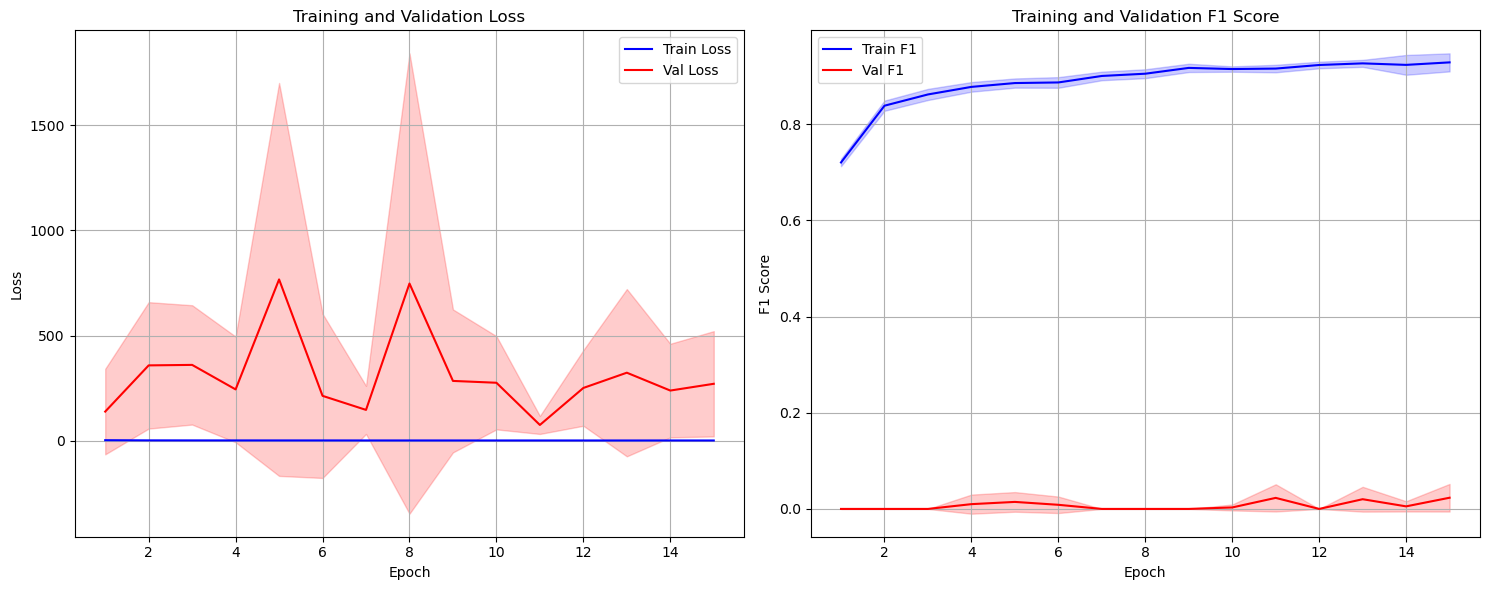

2025-02-25 18:07:34 - INFO - 
Cross-validation results (mean ± std):
2025-02-25 18:07:34 - INFO - Validation Precision: 0.0120 ± 0.0148
2025-02-25 18:07:34 - INFO - Validation Recall: 0.3904 ± 0.4784
2025-02-25 18:07:34 - INFO - Validation F1 Score: 0.0233 ± 0.0287
2025-02-25 18:07:34 - INFO - 
Training final model on entire dataset...
2025-02-25 18:07:35 - INFO - Class weights - Non-seizure: 0.51, Seizure: 17.56
2025-02-25 18:07:35 - INFO - Positive class weight for BCEWithLogitsLoss: 34.12
2025-02-25 18:07:56 - INFO - Epoch 1/15, Loss: 1.5498, F1: 0.7393
2025-02-25 18:08:13 - INFO - Epoch 2/15, Loss: 0.8712, F1: 0.8364
2025-02-25 18:08:32 - INFO - Epoch 3/15, Loss: 0.7413, F1: 0.8544
2025-02-25 18:08:50 - INFO - Epoch 4/15, Loss: 0.5762, F1: 0.8771
2025-02-25 18:09:10 - INFO - Epoch 5/15, Loss: 0.5481, F1: 0.8877
2025-02-25 18:09:38 - INFO - Epoch 6/15, Loss: 0.5505, F1: 0.8897
2025-02-25 18:10:10 - INFO - Epoch 7/15, Loss: 0.4569, F1: 0.9069
2025-02-25 18:10:47 - INFO - Epoch 8/15, 

In [40]:
def main_improved():
    """
    Main function to run the improved seizure detection pipeline with all enhancements
    """
    try:
        # Set up paths using raw string to handle backslashes correctly
        initial_path = Path(r"C:\Users\user\Documents\eeg_data_challenge\BIDS_Siena")
        bids_root = verify_paths(initial_path)
        
        # Load and prepare dataset with spectral features
        logger.info("Loading dataset and extracting spectral features...")
        X, X_spectral, y = prepare_test_dataset(bids_root, add_spectral=True)
        
        # Print dataset statistics
        logger.info(f"Dataset loaded: {X.shape[0]} windows")
        logger.info(f"Seizure windows: {np.sum(y == 1)} ({np.mean(y == 1)*100:.2f}%)")
        logger.info(f"Class imbalance ratio: {np.sum(y == 0) / np.sum(y == 1):.2f}:1")
        
        # Run cross-validation training
        logger.info("Starting cross-validation training...")
        results = train_with_kfold(
            X=X,
            y=y,
            X_spectral=X_spectral,
            n_splits=5,
            n_epochs=15,
            batch_size=64,
            learning_rate=0.0005,
            weight_decay=1e-4,
            dropout_rate=0.5
        )
        
        # Plot results
        plot_kfold_results(results)
        
        # Train final model on entire dataset
        logger.info("\nTraining final model on entire dataset...")
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # Create datasets
        if X_spectral is not None:
            dataset = CombinedSeizureDataset(X, X_spectral, y)
            n_spectral_features = X_spectral.shape[2]
            final_model = ImprovedSeizureModel(
                n_channels=X.shape[1],
                n_spectral_features=n_spectral_features,
                dropout_rate=0.5
            ).to(device)
            use_spectral = True
        else:
            dataset = SeizureDataset(X, y)
            final_model = ImprovedSeizureModel(
                n_channels=X.shape[1],
                dropout_rate=0.5
            ).to(device)
            use_spectral = False
        
        # Create weighted sampler and data loader
        sampler = create_weighted_sampler(y)
        data_loader = DataLoader(dataset, batch_size=64, sampler=sampler)
        
        # Training components
        pos_weight = get_pos_weight(y)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
        optimizer = torch.optim.Adam(
            final_model.parameters(),
            lr=0.0005,
            weight_decay=1e-4
        )
        
        # Train for 15 epochs
        for epoch in range(15):
            train_loss, train_prec, train_rec, train_f1 = train_epoch(
                final_model, data_loader, criterion, optimizer, device, use_spectral
            )
            logger.info(f"Epoch {epoch+1}/15, Loss: {train_loss:.4f}, F1: {train_f1:.4f}")
        
        # Save final model
        torch.save({
            'model_state_dict': final_model.state_dict(),
            'model_config': {
                'n_channels': X.shape[1],
                'n_spectral_features': X_spectral.shape[2] if X_spectral is not None else 0,
                'dropout_rate': 0.5
            },
            'training_config': {
                'learning_rate': 0.0005,
                'weight_decay': 1e-4,
                'batch_size': 64,
                'n_epochs': 15
            },
            'dataset_stats': {
                'n_samples': len(y),
                'n_seizures': int(np.sum(y == 1)),
                'n_non_seizures': int(np.sum(y == 0)),
                'class_ratio': float(np.sum(y == 0) / np.sum(y == 1))
            }
        }, 'improved_seizure_model.pth')
        
        logger.info("Improved model training completed and saved.")
        
    except Exception as e:
        logger.error(f"Error in main function: {str(e)}")
        raise
    
if __name__ == "__main__":
    main_improved()

Model is pretty garbage right now, severe overfitting. Try to add in Ensemble Methods and Temporal Context, Anomaly Detection, going to add in some more datasets as well.